# MovieLens with Collaborative Filtering
## Imports and configs

In [1]:
import os
import sys
from functools import partial
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
sys.path.append('../')
from colabfilter import (
    utils,
    config,
    configured_print_stores,
    configured_query_store_attributes,
    data_processing as dp,
    tensorflow_model as tfm,
    tensorflow_dataset as tfd,
)

# If 'small', dataset is expected in ./data_small/ml-latest-small
# If 'full', dataset is expected in ./data_full/ml-25m
# They are downloadable from https://grouplens.org/datasets/movielens/
config.preset(small_or_full='small', clear_files=False).print()

2024-06-15 21:21:38,969 [INFO]: Created ./data_small/tfrecords
2024-06-15 21:22:34,599 [INFO]: Configurations:
chunk_size       | 1000                                
default_float    | <class 'numpy.float32'>             
default_int      | <class 'numpy.int64'>               
default_seed     | 10                                  
expected_rows    | {'movies': 10000, 'ratings': 100000}
num_processes    | 8                                   
path_data_folder | ./data_small                        
path_pytables    | ./data_small/pytables.h5            
path_raw_dataset | ./data_small/ml-latest-small        
path_tfrecords   | ./data_small/tfrecords              
pbar_leave       | True                                
pbar_show        | True                                


In [2]:
# PyTables paths to be created. Put them in Dict for auto-complete support.
paths = {p: p for p in [
    '/code/user',
    '/code/item',
    '/code/genre',
    '/corr/genre/item_item',
    '/corr/genre/k_th',
    '/corr/rating/item_item',
    '/corr/rating/k_th',
    '/dataset/movies',
    '/dataset/ratings/train',
    '/dataset/ratings/test',
    '/interaction/rating/user_item',
    '/interaction/rating/item_user',
    '/interaction/genre/genre_item',
    '/interaction/genre/item_genre',
    '/nbhd/rating/soft',
    '/nbhd/rating/hard',
    '/nbhd/genre/soft',
    '/nbhd/genre/hard',
]}

## Data

CSV source: https://grouplens.org/datasets/movielens/

![](./img/data_flowchart.png)

### From CSV to PyTables - with some data preprocessing

In [3]:
# Preprocessing tasks
code_dicts = {'user': {}, 'item': {}, 'genre': {}}
def task_encode(df: 'DataFrame', col: str, code_dict: dict) -> 'DataFrame':
    '''Encode a column's values with non-negatvie integral codes in
    `code_dict`, to which new code is added when needed.
    '''
    # apply + dict is faster than pd.Series.map + dict
    encoded = df[col].apply(lambda x: code_dict.get(x, np.nan))
    if (isna := np.isnan(encoded.to_numpy())).sum():
        new_item = df[col][isna].unique()
        new_code = range(x := len(code_dict), x + len(new_item))
        code_dict.update(new_code_dict := dict(zip(new_item, new_code)))
        encoded = df[col].apply(code_dict.get)
    return df.assign(**encoded.to_frame())

def task_explode_genres(df: 'DataFrame') -> 'DataFrame':
    '''Explode movies.csv's genres into multiple columns.'''
    return (
        df
        .assign(genres=df['genres'].str.split('|'))
        .rename(columns={'genres': 'genre'})
        .explode('genre')
    )

# def task_encode_string_cols(df: 'DataFrame', cols: List[str]) -> 'DataFrame':
#     return df.assign(
#         **df[cols].apply(lambda c: c.astype(str).str.encode('utf-8')))

# Load CSVs
i_bytesize = np.dtype(config.default_int).itemsize
f_bytesize = np.dtype(config.default_float).itemsize
# Use only names of Pytables' Column sub-classes for description
# https://www.pytables.org/usersguide/libref/declarative_classes.html#col-sub-classes
ICol = 'Int32Col' if i_bytesize == 4 else 'Int64Col'
FCol = 'Float32Col' if f_bytesize == 4 else 'Float64Col'

unique_indexed_vals = {
    'ratings': dp.load_csv_to_table(
        config.path_pytables,
        csv_path=os.path.join(config.path_raw_dataset, 'ratings.csv'),
        create_table_kwargs={
            'description': {'userId': ICol, 'movieId': ICol, 'rating': FCol},
            'expectedrows': config.expected_rows['ratings'],
        },
        preprocess_tasks=(
            partial(task_encode, col='userId', code_dict=code_dicts['user']),
            partial(task_encode, col='movieId', code_dict=code_dicts['item']),
        ),
        indexing_columns=('userId', 'movieId'),
        target_table=paths['/dataset/ratings/train'],
        target_test_table=paths['/dataset/ratings/test'],
        test_split_size=0.2,
        test_split_id=0, # the 0-th split as test set
    ),
    'movies': dp.load_csv_to_table(
        config.path_pytables,
        csv_path=os.path.join(config.path_raw_dataset, 'movies.csv'),
        create_table_kwargs={
            'description': {'movieId': ICol, 'genre': ICol},
            'expectedrows': config.expected_rows['movies'],
        },
        preprocess_tasks=(
            task_explode_genres,
            partial(task_encode, col='genre', code_dict=code_dicts['genre']),
            partial(task_encode, col='movieId', code_dict=code_dicts['item']),
        ),
        indexing_columns=('genre', 'movieId'),
        target_table=paths['/dataset/movies'],
    ),
}

for name, code_dict in code_dicts.items():
    dp.save_array(
        config.path_pytables,
        target_store=f'/code/{name}',
        array=np.array(list(code_dict.keys())),
    )

for col in ('userId', 'movieId'):
    train = set(unique_indexed_vals['ratings']['train'][col])
    test = set(unique_indexed_vals['ratings']['test'][col])
    print(
        f'Of all {len(train | test)} {col}, '
        f'{len(train - test)} only in train and '
        f'{len(test - train)} only in test.'
    )

Loading ./data_small/ml-latest-small/ratings.csv: 101chunks [00:00, 257.74chunks/s]
Creating index: 100%|████████████████████████████| 2/2 [00:00<00:00, 15.94it/s]
2024-06-15 21:22:35,263 [INFO]: Created stores:
/dataset/ratings/test  | Disk(MB)      0.4 | Memory(MB)      0.4 | Shape (20170, 3) | Type movieId(int64) rating(float32) userId(int64)
/dataset/ratings/train | Disk(MB)      1.6 | Memory(MB)      1.5 | Shape (80666, 3) | Type movieId(int64) rating(float32) userId(int64)

Loading ./data_small/ml-latest-small/movies.csv: 10chunks [00:00, 91.69chunks/s]
Creating index: 100%|████████████████████████████| 2/2 [00:00<00:00, 62.99it/s]
2024-06-15 21:22:35,557 [INFO]: Created stores:
/dataset/movies | Disk(MB)      0.4 | Memory(MB)      0.3 | Shape (22084, 2) | Type genre(int64) movieId(int64)

2024-06-15 21:22:35,682 [INFO]: Created stores:
/code/user | Disk(MB)      0.1 | Memory(MB)      0.0 | Shape (610,) | Type int64

2024-06-15 21:22:35,814 [INFO]: Created stores:
/code/item | Di

### Derive PyTables arrays

#### Interactions - for faster access of each user / item / genre

![](./img/table_to_interaction.png)

Table to Interaction: 100%|██████████| 80666/80666 [00:00<00:00, 782139.09it/s]
2024-06-15 21:22:36,243 [INFO]: Created stores:
/interaction/rating/user_item | Disk(MB)      nan | Memory(MB)      0.6 | Shape (610,) | Type ('<f4', (2,))

Table to Interaction: 100%|██████████| 80666/80666 [00:00<00:00, 339743.24it/s]
2024-06-15 21:22:36,655 [INFO]: Created stores:
/interaction/rating/item_user | Disk(MB)      nan | Memory(MB)      0.6 | Shape (9742,) | Type ('<f4', (2,))

Table to Interaction: 100%|██████████| 22084/22084 [00:00<00:00, 792347.52it/s]
2024-06-15 21:22:36,836 [INFO]: Created stores:
/interaction/genre/genre_item | Disk(MB)      nan | Memory(MB)      0.1 | Shape (20,) | Type ('<f4', (1,))

Table to Interaction: 100%|██████████| 22084/22084 [00:00<00:00, 141399.74it/s]
2024-06-15 21:22:37,158 [INFO]: Created stores:
/interaction/genre/item_genre | Disk(MB)      nan | Memory(MB)      0.1 | Shape (9742,) | Type ('<f4', (1,))



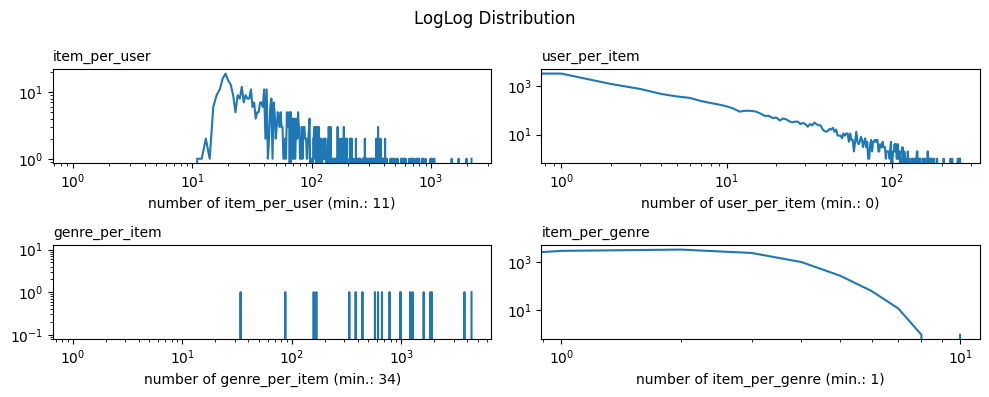

In [4]:
num_user = configured_query_store_attributes(paths['/code/user'])['Shape'][0]
num_item = configured_query_store_attributes(paths['/code/item'])['Shape'][0]
num_genre = configured_query_store_attributes(paths['/code/genre'])['Shape'][0]

# Create interaction arrays, and store the returned distributions
distributions = {
    'item_per_user': dp.interaction_from_table(
        config.path_pytables,
        source_table=paths['/dataset/ratings/train'],
        target_array=paths['/interaction/rating/user_item'],
        sort_by='userId',
        field_1='movieId',
        field_2='rating',
        sort_by_max=num_user - 1,
    ),
    'user_per_item': dp.interaction_from_table(
        config.path_pytables,
        source_table=paths['/dataset/ratings/train'],
        target_array=paths['/interaction/rating/item_user'],
        sort_by='movieId',
        field_1='userId',
        field_2='rating',
        sort_by_max=num_item - 1,
    ),
    'genre_per_item': dp.interaction_from_table(
        config.path_pytables,
        source_table=paths['/dataset/movies'],
        target_array=paths['/interaction/genre/genre_item'],
        sort_by='genre',
        field_1='movieId',
        field_2=None,
        sort_by_max=num_genre - 1,
    ),
    'item_per_genre': dp.interaction_from_table(
        config.path_pytables,
        source_table=paths['/dataset/movies'],
        target_array=paths['/interaction/genre/item_genre'],
        sort_by='movieId',
        field_1='genre',
        field_2=None,
        sort_by_max=num_item - 1,
    ),
}
with utils.plt_subplots(2, 2, figsize=(10, 4)) as (fig, axes):
    fig.suptitle('LogLog Distribution')
    for (name, dist), ax in zip(distributions.items(), axes):
        ax.loglog(dist)
        ax.set_title(name, fontsize='medium', loc='left')
        ax.set_xlabel(f'number of {name} (min.: {(dist > 0).argmax()})')

#### Item-Item correlation - based on (1) ratings of common users; (2) genres

![](./img/correlation.png)

Correlations: 100%|██████████████████████| 9742/9742 [00:09<00:00, 1076.11it/s]
2024-06-15 21:22:47,929 [INFO]: Created stores:
/corr/rating/item_item | Disk(MB)    371.6 | Memory(MB)    362.0 | Shape (9742, 9742) | Type float32
/corr/rating/k_th      | Disk(MB)      0.0 | Memory(MB)      0.0 | Shape (9742,)      | Type float32

Correlations: 100%|███████████████████████| 9742/9742 [00:22<00:00, 430.75it/s]
2024-06-15 21:23:10,762 [INFO]: Created stores:
/corr/genre/item_item | Disk(MB)    371.6 | Memory(MB)    362.0 | Shape (9742, 9742) | Type float32
/corr/genre/k_th      | Disk(MB)      0.0 | Memory(MB)      0.0 | Shape (9742,)      | Type float32



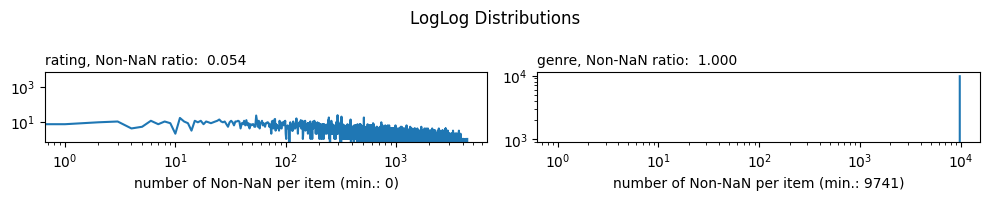

In [5]:
num_item = configured_query_store_attributes(paths['/code/item'])['Shape'][0]

# Create correlation arrays, and store the returned distributions
distributions = {
    'rating': dp.corr_from_interaction(
        config.path_pytables,
        source_item_supp=paths['/interaction/rating/item_user'],
        source_supp_item=paths['/interaction/rating/user_item'],
        target_corr_array=paths['/corr/rating/item_item'],
        target_k_th_corr_array=paths['/corr/rating/k_th'],
        min_support=1, K_th=100, self_correlation=np.nan,
    ),
    'genre': dp.corr_from_interaction(
        config.path_pytables,
        source_item_supp=paths['/interaction/genre/item_genre'],
        source_supp_item=paths['/interaction/genre/genre_item'],
        target_corr_array=paths['/corr/genre/item_item'],
        target_k_th_corr_array=paths['/corr/genre/k_th'],
        min_support=1, K_th=100, self_correlation=np.nan,
    ),
}
with utils.plt_subplots(1, 2, figsize=(10, 2)) as (fig, axes):
    fig.suptitle('LogLog Distributions')
    for (base, dist), ax in zip(distributions.items(), axes):
        min_x = (dist > 0).argmax()
        ratio = (dist * np.arange(len(dist))).sum() / num_item / num_item
        ax.loglog(dist)
        ax.set_title(
            f'{base}, Non-NaN ratio: {ratio: .3f}',
            fontsize='medium', loc='left'
        )
        ax.set_xlabel(f'number of Non-NaN per item (min.: {min_x})')

#### Neighbours

![](./img/neighbours.png)

Neighbours: 100%|██████████████████████████████| 10/10 [00:59<00:00,  5.93s/it]
2024-06-15 21:24:11,078 [INFO]: Created stores:
/nbhd/rating/hard | Disk(MB)     74.3 | Memory(MB)     45.3 | Shape (610, 9742)         | Type int64  
/nbhd/rating/soft | Disk(MB)   7629.4 | Memory(MB)   4533.9 | Shape (610, 9742, 100, 2) | Type float32

Neighbours: 100%|██████████████████████████████| 10/10 [01:10<00:00,  7.02s/it]
2024-06-15 21:25:21,542 [INFO]: Created stores:
/nbhd/genre/hard | Disk(MB)     74.3 | Memory(MB)     45.3 | Shape (610, 9742)         | Type int64  
/nbhd/genre/soft | Disk(MB)   7629.4 | Memory(MB)   4533.9 | Shape (610, 9742, 100, 2) | Type float32



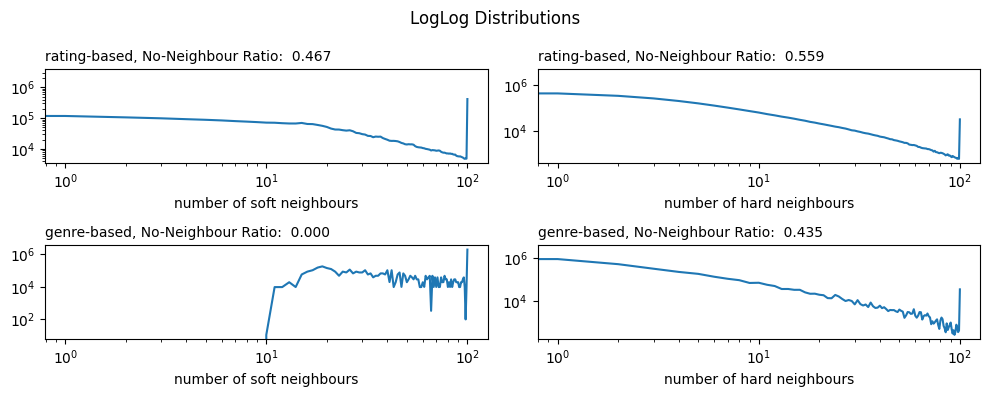

In [6]:
# Create neighbours arrays, and store the returned distributions
# PyTables' write is bottleneck
distributions = {
    'rating': dp.neighbours(
        config.path_pytables,
        source_item_corr=paths['/corr/rating/item_item'],
        source_item_k_th_corr=paths['/corr/rating/k_th'],
        source_supp_item=paths['/interaction/rating/user_item'],
        target_soft_array=paths['/nbhd/rating/soft'],
        target_hard_array=paths['/nbhd/rating/hard'],
    ),
    'genre': dp.neighbours(
        config.path_pytables,
        source_item_corr=paths['/corr/genre/item_item'],
        source_item_k_th_corr=paths['/corr/genre/k_th'],
        source_supp_item=paths['/interaction/rating/user_item'],
        target_soft_array=paths['/nbhd/genre/soft'],
        target_hard_array=paths['/nbhd/genre/hard'],
    ),
}
with utils.plt_subplots(2, 2, figsize=(10, 4)) as (fig, axes):
    fig.suptitle('LogLog Distributions')
    for base, dists in distributions.items():
        for ntype, dist, ax in zip(('soft', 'hard'), dists, axes):
            ax.loglog(dist)
            ax.set_title(
                f'{base}-based, No-Neighbour Ratio: {dist[0]/dist.sum(): .3f}',
                fontsize='medium', loc='left')
            ax.set_xlabel(f'number of {ntype} neighbours')

#### Final list of PyTables data

In [7]:
configured_print_stores()

2024-06-15 21:25:23,462 [INFO]: Created stores:
/code/genre                   | Disk(MB)      0.1 | Memory(MB)      0.0 | Shape (20,)               | Type |S18                                        
/code/item                    | Disk(MB)      0.1 | Memory(MB)      0.1 | Shape (9742,)             | Type int64                                       
/code/user                    | Disk(MB)      0.1 | Memory(MB)      0.0 | Shape (610,)              | Type int64                                       
/corr/genre/item_item         | Disk(MB)    371.6 | Memory(MB)    362.0 | Shape (9742, 9742)        | Type float32                                     
/corr/genre/k_th              | Disk(MB)      0.0 | Memory(MB)      0.0 | Shape (9742,)             | Type float32                                     
/corr/rating/item_item        | Disk(MB)    371.6 | Memory(MB)    362.0 | Shape (9742, 9742)        | Type float32                                     
/corr/rating/k_th             | Disk(MB)

### Create TFRecords for training

In [8]:
_create_tfrecords = partial(
    tfd.create_tfrecords,
    config.path_pytables,
    src_fdbk_rating=paths['/interaction/rating/user_item'],
    src_nbhd_soft_genre=paths['/nbhd/genre/soft'],
    src_nbhd_hard_genre=paths['/nbhd/genre/hard'],
    src_nbhd_soft_rating=paths['/nbhd/rating/soft'],
    src_nbhd_hard_rating=paths['/nbhd/rating/hard'],
)
_create_tfrecords(
    src_ratings=paths['/dataset/ratings/train'],
    number_of_files=10,
    file_prefix='train-',
)
_create_tfrecords(
    src_ratings=paths['/dataset/ratings/test'],
    number_of_files=1,
    file_prefix='test-',
)
print('\nSpecification of each record:')
display(tfd.get_tensor_spec())

Loading TF Records: 100%|███████████████| 20170/20170 [00:35<00:00, 575.11it/s]

Specification of each record:


{'user': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'item': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'rating': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'fdbk_rating_indices': SparseTensorSpec(TensorShape([None, None]), tf.int64),
 'fdbk_rating_scaling': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'nbhd_soft_genre_indices': SparseTensorSpec(TensorShape([None, None]), tf.int64),
 'nbhd_soft_genre_ratings': SparseTensorSpec(TensorShape([None, None]), tf.float32),
 'nbhd_soft_genre_scaling': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'nbhd_hard_genre_indices': SparseTensorSpec(TensorShape([None, None]), tf.int64),
 'nbhd_hard_genre_ratings': SparseTensorSpec(TensorShape([None, None]), tf.float32),
 'nbhd_hard_genre_scaling': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'nbhd_soft_rating_indices': SparseTensorSpec(TensorShape([None, None]), tf.int64),
 'nbhd_soft_rating_ratings': SparseTensorSpec(TensorShape([N

### Final list of created files

In [9]:
for root, subFolders, files in os.walk('./'):
    for file in files:
        if any(kw in file for kw in ['pytables.h5', 'tfrecords']):
            print(os.path.join(root, file))

./data_small/pytables.h5
./data_small/tfrecords/test-000.tfrecords
./data_small/tfrecords/train-000.tfrecords
./data_small/tfrecords/train-001.tfrecords
./data_small/tfrecords/train-002.tfrecords
./data_small/tfrecords/train-003.tfrecords
./data_small/tfrecords/train-004.tfrecords
./data_small/tfrecords/train-005.tfrecords
./data_small/tfrecords/train-006.tfrecords
./data_small/tfrecords/train-007.tfrecords
./data_small/tfrecords/train-008.tfrecords
./data_small/tfrecords/train-009.tfrecords


## Model

### Model form

#### Original form
$$
{
    \begin{eqnarray}
        \hat{\mathbf{R}}_{ui}
        &=&
            \overbrace{
                \underline{\mu} + \underline{b_u} + \underline{b_i} + \underbrace
                                                                                  {
                                                                                      \vphantom{\sum_{j \in \text{N}(u)}}
                                                                                      \underline{\underline{(\mathbf{Q}_i)^T}}
                                                                                  }_{\text{Latent}}
                {
                    \left(
                        \underbrace
                        {
                            \vphantom{\sum_{j \in \text{N}(u)}}
                            \underline{\underline{\mathbf{P}_u}}
                        }_{\text{Latent}} +
                        \underbrace
                        {
                            {| \text{N}(u) |}^{-\frac{1}{2}} \sum_{j \in \text{N}(u)} \underline{\underline{\mathbf{Y}_j}}
                        }_{\text{Implicit Feedback}}
                    \right)
                }
            % \\
            % & & +
            +
                \vphantom{\left(\underbrace{\sum_{j \in \text{N}(u)}}_{\text{implicit feedback}}\right)}
                \underbrace
                {
                    {| \text{R}^k(i; u) |}^{-\frac{1}{2}} \sum_{j \in \text{R}^k(i; u)} {\left( {\mathbf{R}_{uj} - \underline{\underline{\underline{\mathbf{B}_{uj}}}}} \right)}
                    \underline{\underline{\underline{\mathbf{W}_{ij}}}}
                }_{\text{Neighbourhood}}
            % \\
            % & & +
            +
                \vphantom{\left(\underbrace{\sum_{j \in \text{N}(u)}}_{\text{implicit feedback}}\right)}
                \underbrace{
                    {| \text{N}^k(i; u) |}^{-\frac{1}{2}} \sum_{j \in \text{N}^k(i; u)} \underline{\underline{\underline{\mathbf{C}_{ij}}}}
                }_{\text{Neighbourhood on Implicit Feedback}}
            }^{\text{Eq. 16 in [1]}}
        % \\
        % & & +
        +
            \overbrace{
                \vphantom{\left(\underbrace{\sum_{j \in \text{N}(u)}}_{\text{implicit feedback}}\right)}
                \underbrace{
                    \vphantom{\left(\sum_{j \in \text{N}(u)}\right)}
                    (\underline{\underline{\underline{\mathbf{S}}}}\vphantom{}_i)^T \mathbf{R}_u
                }_{\text{SLIM}}
            }^{\text{Eq. 2 in [2]}}
        \\
        \\
        J
        &=&
        \frac{1}{2}\sum_{u,i}\left( \mathbf{R}_{ui} - \hat{\mathbf{R}}_{ui} \right)^2 +
        \text{L2 regularizations}
        \text{, subject to }
        \overbrace{
            \left\{
                \begin{array}{ll}
                    \mathbf{S} \ge 0\\
                    \text{diag}({\mathbf{S}}) = 0\\
                \end{array}
            \right.
        }^{\text{See [2]}}
        \\
        \\
        \text{N}(u) &:& \text{items interacted with the user $u$}
        \\
        \text{R}^k(i;u) &:& \text{top-k neighbours to the item $i$ rated by user $u$}
        \\
        \text{N}^k(i;u) &:& \text{top-k neighbours to the item $i$ interacted with user $u$}
        \\
        \mathbf{R} &:& \text{ratings}
        \\
        \text{Note} &:&\text{single/double/triple-underlined are trainable scalars/vectors/(elements of) matrices}
    \end{eqnarray}
}
$$

[1] Yehuda Koren. 2008. Factorization meets the neighborhood: a multifaceted collaborative filtering model. https://doi.org/10.1145/1401890.1401944

[2] Xia Ning and George Karypis. 2012. Sparse linear methods with side information for top-n recommendations. https://doi.org/10.1145/2365952.2365983

#### Changed form:

##### Changes:

1. Trainable matrices are replaced with low-rank decomposition matrices. E.g. $W_{ij} \rightarrow (\mathbf{W_{1}}_i)^T (\mathbf{W_{2}}_j)$

2. Since ratings data will be reused as interaction data, with the third last term, the second last is dropped.

3. $R_{ui}$ is masked off in the SLIM term, so the second constraint on $\text{S}$ is removed.

$$
    \begin{eqnarray}
        \hat{\mathbf{R}}_{ui}
        &=&
            \underline{\mu} + \underline{b_u} + \underline{b_i} + \underbrace
                                                                              {
                                                                                  \vphantom{\sum_{j \in \text{N}(u)}}
                                                                                  \underline{\underline{(\mathbf{Q}_i)^T}}
                                                                              }_{\text{Latent}}
            {
                \left(
                    \underbrace
                    {
                        \vphantom{\sum_{j \in \text{N}(u)}}
                        \underline{\underline{\mathbf{P}_u}}
                    }_{\text{Latent}} +
                    \underbrace
                    {
                        {| \text{N}(u) |}^{-\frac{1}{2}} \sum_{j \in \text{N}(u)} \underline{\underline{\mathbf{Y}_j}}
                    }_{\text{Option 1: Implicit Feedback}}
                \right)
            }
        % \\
        % & &
        +
            \vphantom{\left(\underbrace{\sum_{j \in \text{N}(u)}}_{\text{implicit feedback}}\right)}
            \underbrace
            {
                {| \text{R}^k(i; u) |}^{-\frac{1}{2}}
                \left[
                    \left(
                        \underline{\underline{(\mathbf{W_{1}}_i)^T}} \sum_{j \in \text{R}^k(i; u)} \underline{\underline{\mathbf{W_{2}}_j}} {(\mathbf{R}_{uj})}
                    \right)
                    -
                    \left(
                        \sum_{j \in \text{R}^k(i; u)} { \underline{\underline{(\mathbf{B_{1}}_u)^T \mathbf{B_{2}}_j (\mathbf{W_{1}}_i)^T \mathbf{W_{2}}_j}}  }
                    \right)
                \right]
            }_{\text{Option 2: Neighbourhood}}
        % \\
        % & &
        +
            \vphantom{\left(\underbrace{\sum_{j \in \text{N}(u)}}_{\text{implicit feedback}}\right)}
            \underbrace{
                \vphantom{\left(\sum_{j \in \text{N}(u)}\right)}
                \underline{\underline{(\mathbf{S_{2}}_i)^T}} \sum_{j \in \text{R}(u) \textbackslash \{i\}} \underline{\underline{\mathbf{S_{1}}_j}}(\mathbf{R}_{uj})
            }_{\text{Option 3: SLIM}}
        \\
        \\
        \\
        J
        &=&
        \frac{1}{2}\sum_{u,i}\left( \mathbf{R}_{ui} - \hat{\mathbf{R}}_{ui} \right)^2
        % \\
        % & &
        +
        \frac{\lambda_0}{2} \left(
            \left\lVert b \right\rVert_F^2
            +
            \left\lVert \mathbf{P} \right\rVert_F^2
            +
            \left\lVert \mathbf{Q} \right\rVert_F^2
        \right)
        +
        \underbrace{
            \frac{\lambda_1}{2} \left(
                \left\lVert \mathbf{Y} \right\rVert_F^2
            \right)
        }_{\text{Option 1}}
        +
        \underbrace{
            \frac{\lambda_2}{2} \left(
                \left\lVert \mathbf{W_1} \right\rVert_F^2
                +
                \left\lVert \mathbf{W_2} \right\rVert_F^2
                +
                \left\lVert \mathbf{B_1} \right\rVert_F^2
                +
                \left\lVert \mathbf{B_2} \right\rVert_F^2
            \right)
        }_{\text{Option 2}}
        +
        \underbrace{
            \frac{\lambda_3}{2} \left(
                \left\lVert \mathbf{S_1} \right\rVert_F^2
                +
                \left\lVert \mathbf{S_2} \right\rVert_F^2
            \right)
        }_{\text{Option 3}}
        % \\
        % & &
        \text{, subject to }
        \left\{
            \begin{array}{ll}
                \mathbf{S_1} \ge 0\\
                \mathbf{S_2} \ge 0\\
            \end{array}
        \right.
    \end{eqnarray}
$$

##### Notes on changed form:
1. Option 1, 2, and 3 may be turned on or off for comparisons.

3. The first term in Option 2 and Option 3 are similar, but the latter (1) covers all items (but $i$) rated by $u$ and (2) has the positivity constraints.

4. All double-underlined trainable vectors have the same (not necessarily though) dimension.

### Model training (hyperparameter search)

`CFModel` is the class for creating a model instance, and it accepts a `CFModelParams` dataclass as its only argument detailing all specifications of the created model. The dataclass may be created with `CFModelParams.with_callable_value()` that can take, as argument value, callables which are called to replace themselves with the returns of the calls. To be more specific, the replacement is by `setattr(params_instance, key, callable_val(params_instance))`.

In [11]:
num_user = configured_query_store_attributes(paths['/code/user'])['Shape'][0]
num_item = configured_query_store_attributes(paths['/code/item'])['Shape'][0]

# Fixed model parameters
fixed_params = {
    'num_user': num_user,
    'num_item': num_item,
    'seed': config.default_seed,
    'epochs': 20,
    'lambda_1': lambda p: p.lambda_0, # same value as lambda_0
    'lambda_2': lambda p: p.lambda_0, # same value as lambda_0
    'lambda_3': lambda p: p.lambda_0, # same value as lambda_0
    'fdbk_prefix': 'fdbk_rating', # only one kind of implicit feedback
    'learning_rate': 0.0005,
    'low_rank': 10,
}
# Searched model parameters
searched_params = {
    # first enlisted, last changed.
    'nbhd_prefix': [
        # There are 4 kinds of neighbours
        'nbhd_soft_rating', 'nbhd_hard_rating',
        'nbhd_soft_genre', 'nbhd_hard_genre',
    ],
    'lambda_0': [.01, .1, .05],
    'option_1': [True, False],
    'option_2': [True, False],
    'option_3': [True, False],
}
# Formatting syntax for records printing
record_field_fmts = {
    'elapsed_time': '12s', # provided by ResultsRecorder
    'params_id': ' 9d', # provided by me
    'epochs': ' 6d', # provided by CFModel
    'train_MSE': ' 9.4f', # provided by CFModel
    'train_MAE': ' 9.4f', # provided by CFModel
    'test_MSE': ' 8.4f', # provided by CFModel
    'test_MAE': ' 8.4f', # provided by CFModel
    'lambda_0': ' 8.1f', # from parameters
    'option_1': ' 8d', # from parameters
    'option_2': ' 8d', # from parameters
    'option_3': ' 8d', # from parameters
    'nbhd_prefix': '16s', # from parameters
    'num_params': ' 10d', # provided by me (though can be by CFModel)
}
print(
    f'Number of searches: '
    f'{len(list(utils.simple_grid_search(searched_params)))}'
)
done_repr = set()
recorder = utils.ResultsRecorder(record_field_fmts)
with config(pbar_leave=False): # config is a dataclass, and a context manager.
    for pid, params in utils.simple_grid_search(searched_params):
        tfm.free_tensorflow_resources()

        # Create a CFModelParams instance
        params.update(fixed_params)
        params = tfm.CFModelParams.with_callables(**params)

        # Check if this has been done before, based on the `params`'s
        # representation custom-defined as `params.repr`.
        # When, for example, option_2 = False, because it disables
        # Neighbourhood, nbhd_prefix's value matters not. The representations
        # are thus the same for runs with option_2 = False and only take
        # different values in nbhd_prefix.
        if params.repr in done_repr:
            continue
        else:
            done_repr.add(params.repr)

        # Build and train a model.
        model = tfm.CFModel(params)
        history = model.fit(
            # Need to get a new dataset each time for reproducibility
            tfd.get_dataset('train-', batch_size=128, shuffle_buffer_size=4096),
            tfd.get_dataset('test-', batch_size=1024, shuffle_buffer_size=0),
            recorder_update_func=partial(
                # A callback for logging & printing each epoch's result
                recorder.update,
                params_id=pid,
                num_params=model.num_trainable_parameters,
                **params.as_dict(),
            ),
        )
        recorder.print_separator_line()

Number of searches: 96
elapsed_time | params_id | epochs | train_MSE | train_MAE | test_MSE | test_MAE | lambda_0 | option_1 | option_2 | option_3 | nbhd_prefix      | num_params                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
------------ | --------- | ------ | ------

In [12]:
# Save results to disk
pd.DataFrame(recorder.field_vals).to_csv('./data_small/search_results.csv', index=False)

### Search results

#### Best Test MAEs

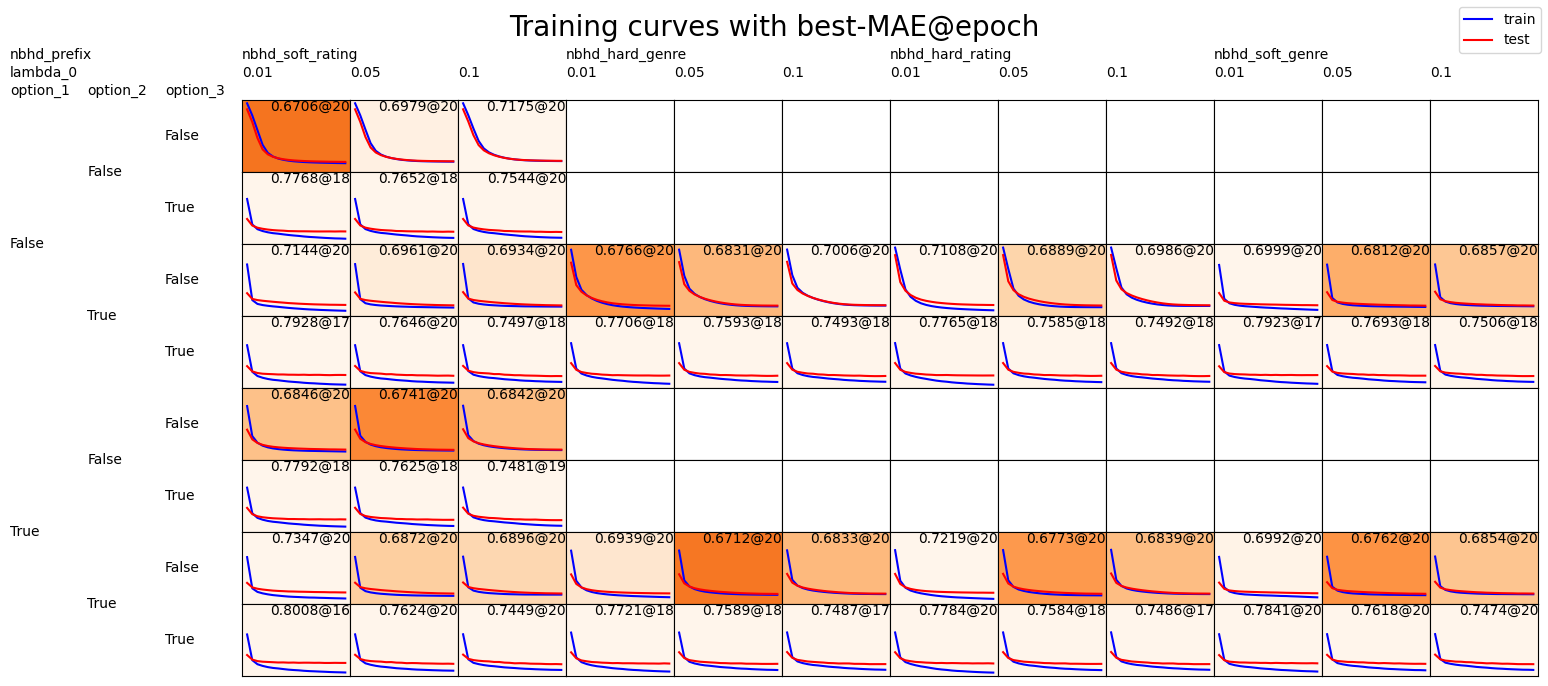

In [13]:
df = (
    pd
    .read_csv('./data_small/search_results.csv')
    .sort_values('epochs')
    .groupby(['option_1', 'option_2', 'option_3', 'nbhd_prefix', 'lambda_0'])
    [['train_MAE', 'test_MAE']]
    .apply(np.array)
    .unstack([-2, -1])
)
with utils.plt_pivot_table(
        df,
        subplot_size_in_pixel=(60, 40),
        suptitle_text='Training curves with best-MAE@epoch',
        suptitle_font_size=20,
    ) as (fig, fig_size_in_inch, get_subplots_func):
    axes = get_subplots_func(sharex=True, sharey=True)
    handles = None

    def gradient_color(val, vmin=.65, vmax=.70, alpha=1.):
        cmap_x = (np.clip(val, vmin, vmax) - vmin) / (vmax - vmin)
        return plt.get_cmap('Oranges_r')(cmap_x, alpha)

    for y, ax in zip(df.to_numpy().flatten(), axes.flatten()):
        if not isinstance(y, np.ndarray):
            continue

        y_train, y_test = y.T
        best_test = np.min(y_test)
        best_epoch = np.argmin(y_test) + 1
        best_text = f'{best_test:.4f}@{best_epoch}'
        ax.plot(y_train, color='blue', label='train')
        ax.plot(y_test, color='red', label='test')
        ax.set_facecolor(gradient_color(best_test))
        ax.text(1, 1, best_text, transform=ax.transAxes, ha='right', va='top')

        if handles is None:
            handles = ax.lines

    fig.legend(handles=handles)